Copyright 2023 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# ResNet on CIFAR10 with Haiku and Optax.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/google-deepmind/optax/blob/master/examples/cifar10_resnet.ipynb)

This notebook trains a residual network (ResNet) with optax on CIFAR10 or CIFAR100.

In [1]:
import functools
# typing definitions
from typing import Tuple

import haiku as hk
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
import numpy as np
import optax
import tensorflow as tf
import tensorflow_datasets as tfds

# hide the GPU from tensorflow, otherwise it might
# reserve memory on it
tf.config.experimental.set_visible_devices([], "GPU")

# Show on which platform JAX is running.
print("JAX running on", jax.devices()[0].platform.upper())

JAX running on GPU


In [2]:
# @markdown Total number of epochs to train for:
MAX_EPOCHS = 50  # @param{type:"integer"}
# @markdown Number of samples in each batch:
BATCH_SIZE = 128  # @param{type:"integer"}
# @markdown The initial learning rate for the optimizer:
PEAK_LR = 0.12  # @param{type:"number"}
# @markdown The model architecture for the neural network. Can be one of `'resnet1'`, `'resnet18'`, `'resnet34'`, `'resnet50'`, `'resnet101'`, `'resnet152'`, `'resnet200'`:
MODEL = "resnet18"  # @param{type:"string"}
# @markdown The dataset to use. Could be either `'cifar10'` or `'cifar100'`:
DATASET = "cifar10"  # @param{type:"string"}
# @markdown The amount of L2 regularization (aka weight decay) to use:
L2_REG = 1e-4  # @param{type:"number"}

CIFAR10 and CIFAR100 are composed of 32x32 images with 3 channels (RGB). We'll now load the dataset using `tensorflow_datasets` and display a few of the first samples.

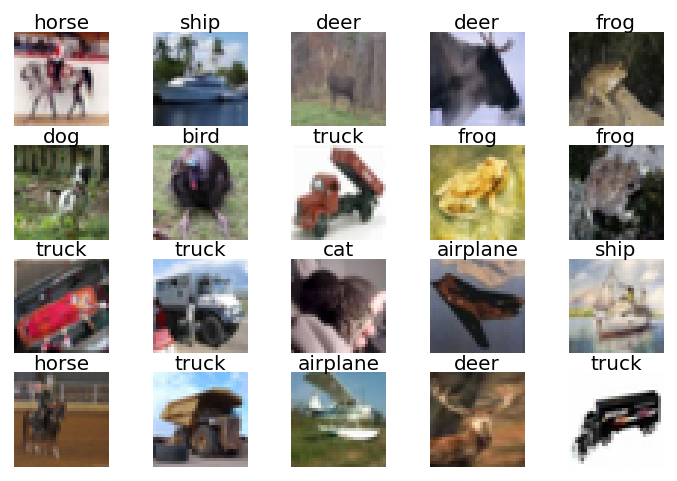

In [3]:
(train_loader, test_loader), info = tfds.load(
    DATASET, split=["train", "test"], as_supervised=True, with_info=True
)
NUM_CLASSES = info.features["label"].num_classes
IMG_SIZE = info.features["image"].shape


def plot_sample_images(loader):
  loader_iter = iter(loader)
  _, axes = plt.subplots(nrows=4, ncols=5, figsize=(6, 4))
  for i in range(4):
    for j in range(5):
      image, label = next(loader_iter)
      axes[i, j].imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
      axes[i, j].set_axis_off()
      axes[i, j].set_title(
          info.features["label"].names[label], fontsize=10, y=0.9
      )


plot_sample_images(train_loader)

The accuracy of the model can be improved significantly through data augmentation. That is, instead of training on the above images, we'll generate random modifications of the images and train on those. This is done by using the `transform` argument of `tfds.load` to apply a random crop, random horizontal flip, and random color jittering.

In the next cell we show an instance of these transformations on the above images.

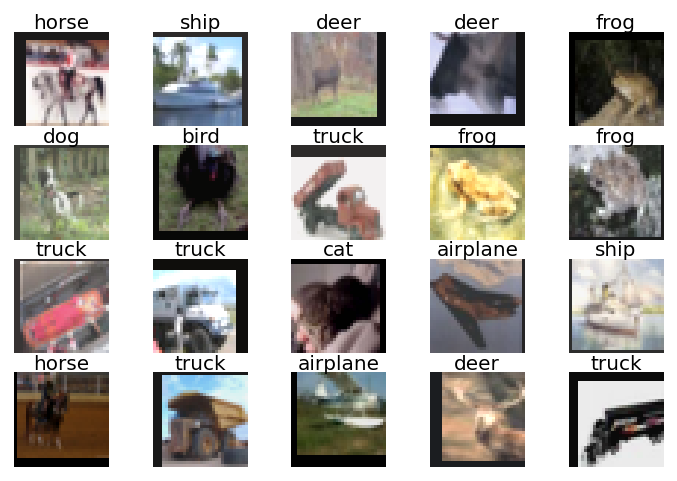

In [4]:
def augment(image, label):
  """Data augmentation for CIFAR10."""
  image = tf.image.resize_with_crop_or_pad(image, 40, 40)
  image = tf.image.random_crop(image, [32, 32, 3])
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=0.2)
  image = tf.image.random_contrast(image, 0.8, 1.2)
  image = tf.image.random_saturation(image, 0.8, 1.2)
  return image, label


train_loader_augmented = train_loader.map(augment)
plot_sample_images(train_loader_augmented)

We now shuffle the data in the train set and create batches of size `'BATCH_SIZE'` for both train and test set

In [5]:
train_loader_batched = train_loader_augmented.shuffle(
    buffer_size=10_000, reshuffle_each_iteration=True
).batch(BATCH_SIZE, drop_remainder=True)

test_loader_batched = test_loader.batch(BATCH_SIZE, drop_remainder=True)

Now that the data is ready, let's define the model. For this, we will use the residual networks defined in haiku.

Note that we're overwriting some of the default parameters in this implementation, such as the `kernel_shape` and `stride` of the convolutions. The default values of (7, 7) and 2 respectively are too large for the small 32x32 images in this dataset, so we reduce these parameters to (3, 3) and 1 respectively.


In [6]:
initial_conv_config = {"kernel_shape": (3, 3), "stride": 1, "padding": "SAME"}

RESNET_CONSTRUCTOR = {
    "resnet18": hk.nets.ResNet18,
    "resnet34": hk.nets.ResNet34,
    "resnet50": hk.nets.ResNet50,
    "resnet101": hk.nets.ResNet101,
    "resnet152": hk.nets.ResNet152,
    "resnet200": hk.nets.ResNet200,
}


# haiku definition for the forward pass
@hk.transform_with_state
def net(inputs, is_training):
  inputs = inputs.astype(jnp.float32) / 255.0
  return RESNET_CONSTRUCTOR[MODEL](
      num_classes=NUM_CLASSES,
      resnet_v2=False,
      initial_conv_config=initial_conv_config,
  )(inputs, is_training=is_training)


@functools.partial(jax.jit, static_argnums=(3,))
def loss_accuracy(
    params: hk.Params,
    net_state: hk.State,
    batch: Tuple[jnp.ndarray, jnp.ndarray],
    train: bool = True,
):
  """Compute loss and accuracy over a mini-batch.

  Args:
    params: parameters of the model.
    net_state: state of the model.
    batch: tuple of (inputs, labels).
    train: whether to use train mode or eval mode.

  Returns:
    loss: float
    aux: dictionary with keys "accuracy" and "net_state".
  """
  inputs, labels = batch
  logits, net_state = net.apply(
      params, net_state, None, inputs, is_training=train
  )
  mean_loss = optax.softmax_cross_entropy_with_integer_labels(
      logits=logits, labels=labels
  ).mean()
  accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == labels)
  # compute regularization on all except batchnorm parameters
  l2_params = {k: v for k, v in var_params.items() if "batchnorm" not in k}
  sqnorm = optax.tree_utils.tree_vdot(l2_params, l2_params)
  obj_loss = mean_loss + 0.5 * L2_REG * sqnorm
  return obj_loss, {"accuracy": accuracy, "net_state": net_state}

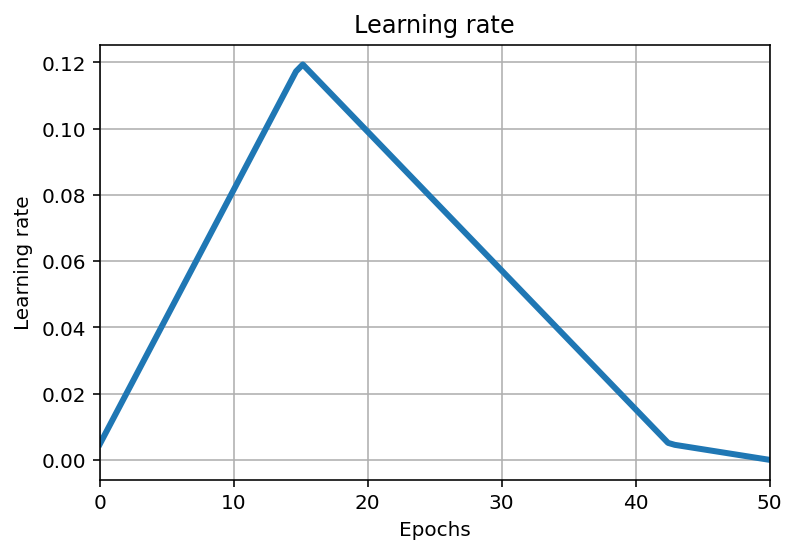

In [7]:
iter_per_epoch_train = info.splits["train"].num_examples // BATCH_SIZE
lr_schedule = optax.linear_onecycle_schedule(
    MAX_EPOCHS * iter_per_epoch_train, 0.12
)

iterate_subsample = np.linspace(0, MAX_EPOCHS * iter_per_epoch_train, 100)
plt.plot(
    np.linspace(0, MAX_EPOCHS, len(iterate_subsample)),
    [lr_schedule(i) for i in iterate_subsample],
    lw=3,
)
plt.title("Learning rate")
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.grid()
plt.xlim((0, MAX_EPOCHS))
plt.show()

In the next two cells we'll initialize the variables and states. We also define a convenience function `dataset_stats` that we'll call once per epoch to collect the loss and accuracy of our solver over the test set.

In [8]:
solver = optax.sgd(lr_schedule, momentum=0.9)

# Initialize parameters.
rng = jax.random.PRNGKey(0)
dummy_data = jnp.ones((1,) + IMG_SIZE, dtype=jnp.float32)
dummy_targets = jnp.ones(1, int)
var_params, var_net_state = net.init(rng, dummy_data, is_training=True)

In [9]:
# Define parameter update function
var_solver_state = solver.init(var_params)


def dataset_stats(params, net_state, data_loader):
  """Compute loss and accuracy over the dataset `data_loader` for `max_iter` items."""
  all_accuracy = []
  all_loss = []
  for cur_batch in data_loader.as_numpy_iterator():
    batch_loss, batch_aux = loss_accuracy(
        params, net_state, cur_batch, train=False
    )
    all_loss.append(batch_loss)
    all_accuracy.append(batch_aux["accuracy"])
  return {"loss": np.mean(all_loss), "accuracy": np.mean(all_accuracy)}

Finally, we do the actual training. The next cell performs `'MAX_EPOCHS'` epochs of training. Within each epoch we iterate over the batched loader `train_loader_batched`, and once per epoch we also compute the test set accuracy and loss.

In [10]:
train_accuracy = []
train_losses = []
# Compute test set accuracy at initialization
test_stats = dataset_stats(var_params, var_net_state, test_loader_batched)
test_accuracy = [test_stats["accuracy"]]
test_losses = [test_stats["loss"]]


# one step update
@jax.jit
def train_step(params, net_state, solver_state, batch):
  (loss, aux), grad = jax.value_and_grad(loss_accuracy, has_aux=True)(
      params, net_state, batch, train=True
  )
  updates, solver_state = solver.update(grad, solver_state)
  params = optax.apply_updates(params, updates)
  return params, solver_state, loss, aux


# Training loop.
for epoch in range(MAX_EPOCHS):
  train_accuracy_epoch = []
  train_losses_epoch = []

  for train_batch in train_loader_batched.as_numpy_iterator():
    var_params, var_solver_state, train_loss, train_aux = train_step(
        var_params, var_net_state, var_solver_state, train_batch
    )
    var_net_state = train_aux["net_state"]
    train_accuracy_epoch.append(train_aux["accuracy"])
    train_losses_epoch.append(train_loss)

  # once per epoch, make a pass over the test set to compute accuracy
  test_stats = dataset_stats(var_params, var_net_state, test_loader_batched)
  test_accuracy.append(test_stats["accuracy"])
  test_losses.append(test_stats["loss"])
  train_accuracy.append(np.mean(train_accuracy_epoch))
  train_losses.append(np.mean(train_losses_epoch))

  # print accuracies every 10 epochs
  if epoch % 10 == 0:
    print("epoch: ", epoch)
    print("test set accuracy", test_accuracy[-1])
    print("train set accuracy", np.mean(train_accuracy_epoch))

epoch:  0
test set accuracy 0.5592949
train set accuracy 0.40004006
epoch:  10
test set accuracy 0.8025841
train set accuracy 0.8295673
epoch:  20
test set accuracy 0.86999196
train set accuracy 0.90703124
epoch:  30
test set accuracy 0.8936298
train set accuracy 0.95058095
epoch:  40
test set accuracy 0.9129607
train set accuracy 0.9808494


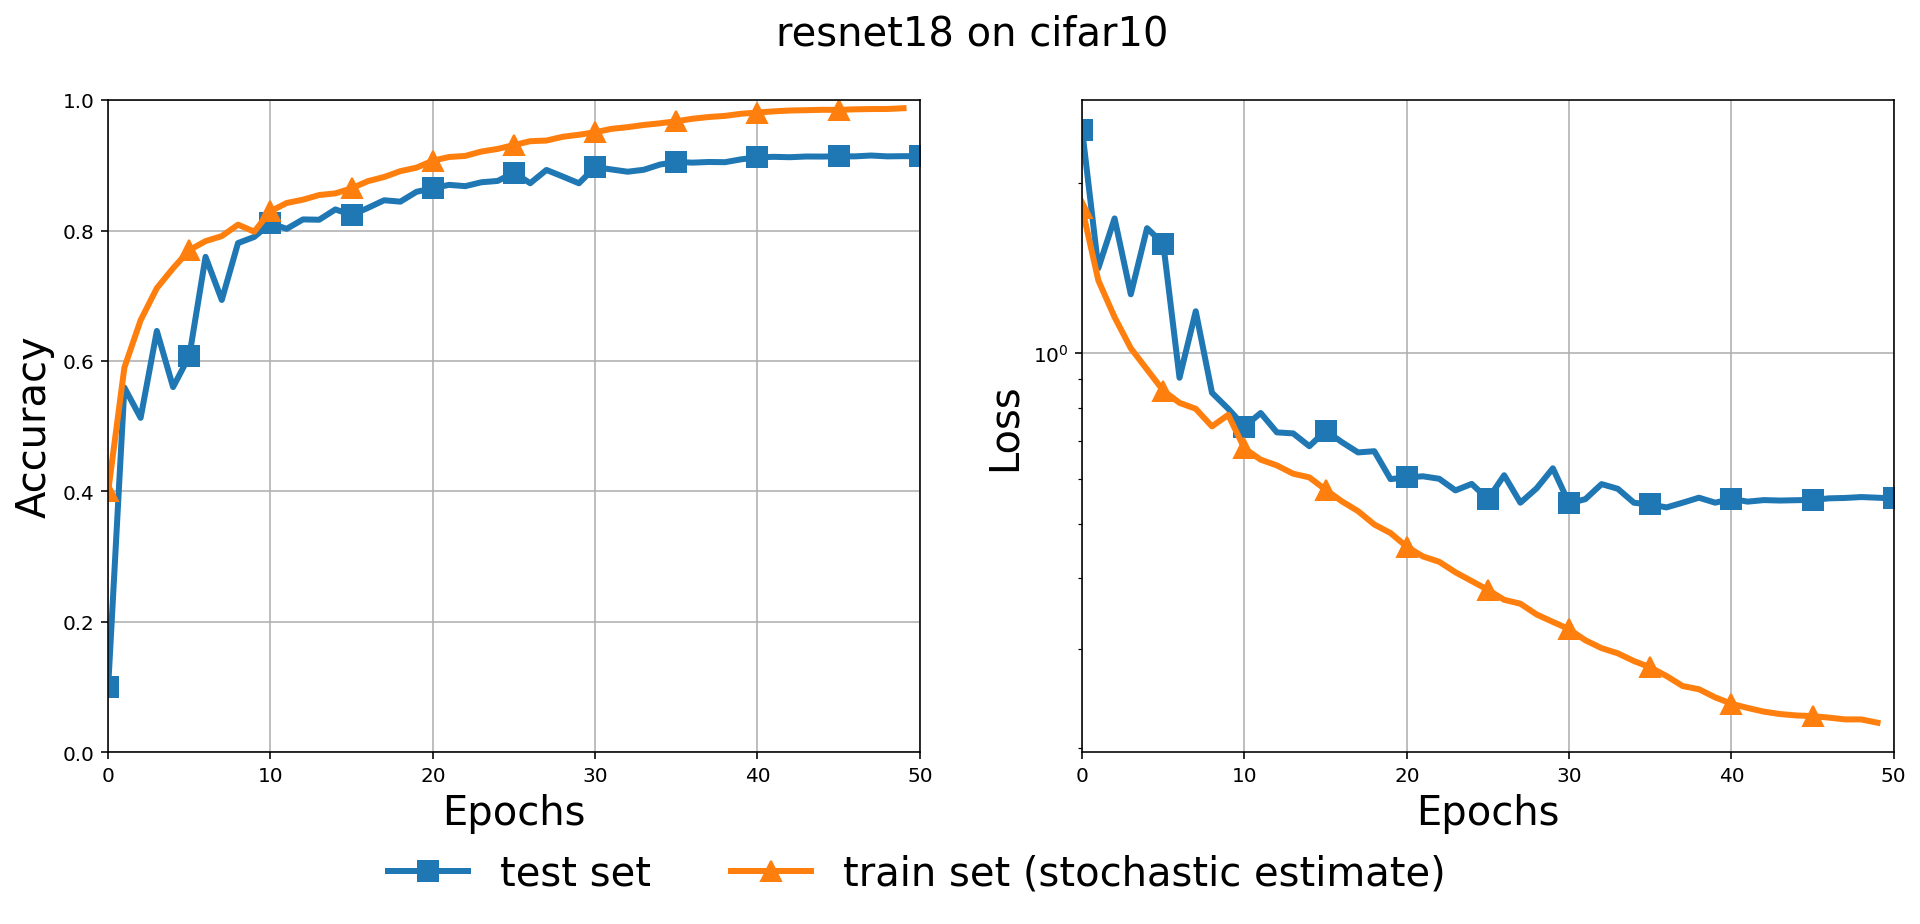

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

plt.suptitle(f"{MODEL} on {DATASET}", fontsize=20)

ax1.plot(
    test_accuracy,
    lw=3,
    marker="s",
    markevery=5,
    markersize=10,
    label="test set",
)
ax1.plot(
    train_accuracy,
    lw=3,
    marker="^",
    markevery=5,
    markersize=10,
    label="train set (stochastic estimate)",
)
ax1.set_ylabel("Accuracy", fontsize=20)
ax1.grid()
ax1.set_xlabel("Epochs", fontsize=20)
ax1.set_xlim((0, MAX_EPOCHS))
ax1.set_ylim((0, 1))

ax2.plot(
    test_losses, lw=3, marker="s", markevery=5, markersize=10, label="test set"
)
ax2.plot(
    train_losses,
    lw=3,
    marker="^",
    markevery=5,
    markersize=10,
    label="train set (stochastic estimate)",
)
ax2.set_ylabel("Loss", fontsize=20)
ax2.grid()
ax2.set_xlabel("Epochs", fontsize=20)
ax2.set_xlim((0, MAX_EPOCHS))

# set legend at the bottom of the plot
ax1.legend(
    frameon=False, fontsize=20, ncol=2, loc=2, bbox_to_anchor=(0.3, -0.1)
)

ax2.set_yscale("log")

plt.show()

In [12]:
# Finally, let's print the test set accuracy
print("Final accuracy on test set: ", test_accuracy[-1])

Final accuracy on test set:  0.91376203
